In [1]:
import time
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import (roc_auc_score, f1_score, roc_curve, auc, 
                             confusion_matrix, precision_recall_curve, make_scorer)


from tqdm import tqdm

# Functions and configurations

In [2]:
RANDOM_STATE = 35

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def split_data(X, Y, kfold=None):
    
    X_train, X_test, Y_train, Y_test = train_test_split(X,  Y, test_size = 0.2,  stratify=Y)
    
    if kfold:
        
        skf = StratifiedKFold(n_splits=kfold, shuffle=True)

        kfold_5 = skf.split(X_train, Y_train)
        
        i=0
        indices_split = {}

        for train, val in kfold_5:

            indices_split[f"fold_{i}"] = (train, val)

            i += 1
        
        return indices_split, (X_test, Y_test)
    
    X_train, X_val, Y_train, Y_val = train_test_split(X_train,  Y_train, test_size = 0.2,  stratify=Y_train)
    
    return (X_train, X_val, X_test), (Y_train, Y_val, Y_test)

In [4]:
def compare_models(X, Y, classifiers=None, indices_split=None, scaling=None):
    """
    Args:
    
    X, Y - if calssifiers == None and indices_split == None, X and Y are tuples
    that contains (X_train, X_val) e (Y_train, Y_test), otherwise X, Y
    are np.array of all dataset to be separeted using the indices_split
    into n fold.
    classifiers - dictionary of classifiers or a single classifier.
    
    
    """
    history = {}
    
    if indices_split and classifiers:

        for clf_name, clf, (train, val) in zip(classifiers.keys(), classifiers.values(), indices_split.values()):

            print(f"\n Evaluating the model {clf_name}")
            
            if scaler:
                scaler = MinMaxScaler()
                X_train = scaler.fit_transform(X[train])
                X_val = scaler.fit(X[val])

            #Training 

            y_hat_train = clf.predict(X_train)

            rf_train_roc_auc_score = roc_auc_score(Y[train], y_hat_train)
            rf_train_f1_score = f1_score(Y[train], y_hat_train, average="weighted")

            #val

            y_hat_val = clf.predict(X_val)

            rf_val_roc_auc_score = roc_auc_score(Y[val], y_hat_val)
            rf_val_f1_score = f1_score(Y[val], y_hat_val, average="weighted")
            precision, recall, thresholds_pr = precision_recall_curve(Y[val], y_hat_val)
            AUC_PRcurve= auc(recall, precision)
            fpr, tpr, thresholds = roc_curve(Y[val], y_hat_val)

            print(f"F1 score - Train: {rf_train_f1_score} / val: {rf_val_f1_score}")
            print(f"ROC AUC score - Train: {rf_train_roc_auc_score} / val: {rf_val_roc_auc_score}")
            print(f"PR AUC score - val: {AUC_PRcurve}")

            history[clf_name] = {"y_hat_train": y_hat_train, "y_hat_val": y_hat_val,
                                 "pr": (precision, recall, AUC_PRcurve), "roc": (fpr, tpr, thresholds)}
    else:
        clf = classifiers
        #Train
        X_train, X_val = X
        y_train, y_val = Y
        
        if scaler:
            scaler = MinMaxScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.fit(X_val)

        y_hat_train = clf.predict(X_train)

        rf_train_roc_auc_score = roc_auc_score(y_train, y_hat_train)
        rf_train_f1_score = f1_score(y_train, y_hat_train, average="weighted")

        #val

        y_hat_val = clf.predict(X_val)

        rf_val_roc_auc_score = roc_auc_score(y_val, y_hat_val)
        rf_val_f1_score = f1_score(y_val, y_hat_val, average="weighted")
        precision, recall, thresholds_pr = precision_recall_curve(y_val, y_hat_val)
        AUC_PRcurve= auc(recall, precision)
        fpr, tpr, thresholds = roc_curve(y_val, y_hat_val)

        print(f"F1 score - Train: {rf_train_f1_score} / val: {rf_val_f1_score}")
        print(f"ROC AUC score - Train: {rf_train_roc_auc_score} / val: {rf_val_roc_auc_score}")
        print(f"PR AUC score - val: {AUC_PRcurve}")

        history["clf_0"] = {"y_hat_train": y_hat_train, "y_hat_val": y_hat_val,
                            "pr": (precision, recall, AUC_PRcurve), "roc": (fpr, tpr, thresholds)}
        
    return history

In [5]:
def plot_pr_curve(history):
    
    plt.figure(1)
    
    for model_name, model_eval in zip(history.keys(), history.values()):
    
        precision, recall, AUC_PRcurve = model_eval["pr"]
    
        # plot no skill
        plt.plot([0, 1], [0.5, 0.5], linestyle='--')
        #plot PR curve
        plt.plot(precision, recall, label = "{} AUC = {:0.2f}".format(model_name, AUC_PRcurve), lw = 3, alpha = 0.7)
    plt.xlabel('Precision', fontsize = 14)
    plt.ylabel('Recall', fontsize = 14)
    plt.title('Precision-Recall Curve', fontsize = 18)
    plt.legend(loc='best')
    plt.show()

In [6]:
def plot_roc_auc_curve(history):
    
    plt.figure()
    
    for model_name, model_eval in zip(history.keys(), history.values()):

        fpr, tpr, thresholds = model_eval["roc"]
        
        roc_auc = auc(fpr, tpr)

        lw = 2
        plt.plot(
            fpr,
            tpr,
            label=f"{model_name} ROC curve (area = %0.2f)" % roc_auc,
        )
        plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
        
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    
    plt.show()


In [7]:
def split_indices_stritify(y, proportion, rate_positive):
 
    """
    Args:
    
    proportion - is the proportion of the original data we want to slice
    rate_positive - rate of the positive label of the imbaleced data
    
    """
    array_size = len(y)
    
    new_size = proportion*array_size
    
    positive_size = int(rate_positive * new_size)
    negative_size = int((1 - rate_positive) * new_size)
    
    positive_indicies = np.argwhere(Y==1)[0:positive_size]
    negative_indices = np.argwhere(Y==0)[0:negative_size]
    
    return positive_indicies, negative_indices

In [8]:
def plot_cm(labels, predictions, model_name):
    print(model_name)
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

In [24]:
def train_model(model, X, Y, indices_split=None, scaling=False):
    
        
    if indices_split:
        i = 0
        classifiers = {}
        for train, val in indices_split.values():
            
            if scaling:
                scaler = MinMaxScaler()
                X_train = scaler.fit_transform(X[train])
            else:
                X_train = X[train]
                
            print(f"Training clf {i}")

            model.fit(X_train, Y[train])

            classifiers[f"clf_{i}"] = classifier

            i += 1
        return classifiers
    
    if scaling:
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
        
    model.fit(X, Y)
    
    return model
    

In [10]:
def pr_auc_score(y_true, y_score):
    """
    Generates the Area Under the Curve for precision and recall.
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    return auc(recall, precision)

# Processing data

In [11]:
data_raw = pd.read_csv("dataset/processed_features.csv")


In [12]:
data_raw.corr()

,account_id,device_id,balance,processed_at,is_fraud,age_range,number_of_selfies_sent,time_client,cash_out_type_1,cash_out_type_2,cash_out_type_3,cash_out_type_6
account_id,1.000000,0.936605,-0.115446,0.030805,-0.031733,0.014728,-0.011119,-0.124930,-0.024468,0.314274,-0.312839,0.001893
device_id,0.936605,1.000000,-0.120909,0.030237,-0.032270,0.010916,-0.010421,-0.128533,-0.021081,0.339309,-0.339272,0.001675
balance,-0.115446,-0.120909,1.000000,0.013672,-0.002463,0.041070,-0.015854,0.278847,0.019471,0.036898,-0.043073,-0.000271
processed_at,0.030805,0.030237,0.013672,1.000000,-0.006212,0.005170,-0.010542,0.034895,-0.000934,0.011392,-0.011319,-0.001043
is_fraud,-0.031733,-0.032270,-0.002463,-0.006212,1.000000,0.001232,0.000773,-0.001799,0.005346,0.017931,-0.019762,-0.000132
age_range,0.014728,0.010916,0.041070,0.005170,0.001232,1.000000,-0.008867,-0.025235,0.002038,0.043571,-0.044924,0.001572
number_of_selfies_sent,-0.011119,-0.010421,-0.015854,-0.010542,0.000773,-0.008867,1.000000,0.134589,0.006826,-0.008444,0.006654,-0.000253
time_client,-0.124930,-0.128533,0.278847,0.034895,-0.001799,-0.025235,0.134589,1.000000,0.014227,-0.022264,0.018509,0.014154
cash_out_type_1,-0.024468,-0.021081,0.019471,-0.000934,0.005346,0.002038,0.006826,0.014227,1.000000,-0.200642,-0.079909,-0.000421
cash_out_type_2,0.314274,0.339309,0.036898,0.011392,0.017931,0.043571,-0.008444,-0.022264,-0.200642,1.000000,-0.960473,-0.005063


In [13]:
data = data_raw.copy()

data.drop("account_id", axis=1, inplace=True)

In [14]:
data.isna().sum()

device_id                 0
balance                   0
processed_at              0
is_fraud                  0
age_range                 0
number_of_selfies_sent    0
time_client               0
cash_out_type_1           0
cash_out_type_2           0
cash_out_type_3           0
cash_out_type_6           0
dtype: int64

In [15]:
Y = data.is_fraud.to_numpy()
X = data.copy().drop("is_fraud", axis = 1).to_numpy()

print("X shape:", X.shape)
print("Y shape:", Y.shape)

size_negatives, size_positives = list(np.bincount(Y))

all_pos_rate = size_positives / (size_positives + size_negatives)
all_neg_rate = size_negatives / (size_positives + size_negatives)

print(f"Proportion Positives {all_pos_rate}  / negatives {all_neg_rate}")

X shape: (940935, 10)
Y shape: (940935,)
Proportion Positives 0.0016313560447852402  / negatives 0.9983686439552147


In [55]:
#slice the dataset case testing models

positive_indicies, negative_indices = split_indices_stritify(Y, 0.1, all_pos_rate)

X_2 = np.concatenate((X[negative_indices,:], X[positive_indicies,:]), axis=0)
X_2 = X_2.reshape(X_2.shape[0], -1)
Y_2 = np.concatenate((Y[negative_indices], Y[positive_indicies]))
Y_2 = Y_2.reshape(Y_2.shape[0])

size_negatives, size_positives = list(np.bincount(Y_2))

pos_rate = size_positives / (size_positives + size_negatives)
neg_rate = size_negatives / (size_positives + size_negatives)

print(f"X shape {X_2.shape} / Y shape {Y_2.shape}")
print(f"Proportion Positives {pos_rate}  / negatives {neg_rate}")


X_pack,  Y_pack = split_data(X_2, Y_2, kfold=None)
X_train, X_val, X_test = X_pack
Y_train, Y_val, Y_test  = Y_pack

TypeError: tuple indices must be integers or slices, not tuple

In [58]:
n_class_count = np.bincount(Y_train)
n_class_0 = n_class_count[0]
n_class_1 = n_class_count[1]

total = n_class_0 + n_class_1

class_weight_1 = (1/n_class_0) * (2*total)
class_weight_0 = (1/n_class_1) * (2*total)

class_weight = {0:class_weight_0, 1:class_weight_1}

print("Class 0 weigth: ", class_weight_0, "\nClass 1 weigth: ", class_weight_1)

Class 0 weigth:  1226.4725050916495 
Class 1 weigth:  2.0032667127954014


# Scaling

In [16]:
X_pack,  Y_pack = split_data(X, Y, kfold=None)
X_train, X_val, X_test = X_pack
Y_train, Y_val, Y_test  = Y_pack

In [17]:
scaler = MinMaxScaler()

train_features = scaler.fit_transform(X_train)
val_features = scaler.transform(X_val)
test_features = scaler.transform(X_test)


In [18]:
X_train.shape

(602198, 10)

# GridSearch

In [86]:

#model, this cell take some time. on CPU with no parallelism
pr_auc_score = make_scorer(pr_auc_score)

params = {
          "n_estimators": [400, 500],"max_depth":[None, 50],
          "min_samples_split":[1,2],"min_samples_leaf": [1,2],
          "oob_score": [True], "max_samples": [1,10,100]
}


rf_classifier = RandomForestClassifier(random_state=RANDOM_STATE, class_weight= "balanced_subsample", 
                                       verbose=1, n_jobs=-1)

clf = GridSearchCV(rf_classifier, params, scoring=pr_auc_score, 
                   refit=False, return_train_score=True, verbose=2, n_jobs=-1)


In [87]:
classifiers = train_model(clf, train_features, Y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/ymquint/Documents/Economapas/economapas/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
80 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ymquint/Documents/Economapas/economapas/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ymquint/Documents/Economapas/economapas/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 459, in fit
    for i, t in enumerate(trees)
  File "/Users/ymquint/Documents/Economapas/economapas/lib/python3.7/site-packages

[CV] END max_depth=None, max_samples=10, min_samples_leaf=1, min_samples_split=1, n_estimators=400, oob_score=True; total time=   1.7s
[CV] END max_depth=None, max_samples=10, min_samples_leaf=1, min_samples_split=2, n_estimators=400, oob_score=True; total time= 1.4min
[CV] END max_depth=None, max_samples=10, min_samples_leaf=2, min_samples_split=1, n_estimators=400, oob_score=True; total time=   1.3s
[CV] END max_depth=None, max_samples=10, min_samples_leaf=2, min_samples_split=1, n_estimators=400, oob_score=True; total time=   1.2s
[CV] END max_depth=None, max_samples=10, min_samples_leaf=2, min_samples_split=2, n_estimators=400, oob_score=True; total time= 1.2min
[CV] END max_depth=None, max_samples=10, min_samples_leaf=2, min_samples_split=2, n_estimators=400, oob_score=True; total time= 1.3min
[CV] END max_depth=None, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=400, oob_score=True; total time= 1.8min
[CV] END max_depth=None, max_samples=10000, min_samp

[CV] END max_depth=None, max_samples=10, min_samples_leaf=1, min_samples_split=1, n_estimators=400, oob_score=True; total time=   1.3s
[CV] END max_depth=None, max_samples=10, min_samples_leaf=1, min_samples_split=1, n_estimators=400, oob_score=True; total time=   1.6s
[CV] END max_depth=None, max_samples=10, min_samples_leaf=1, min_samples_split=2, n_estimators=400, oob_score=True; total time= 1.4min
[CV] END max_depth=None, max_samples=10, min_samples_leaf=2, min_samples_split=1, n_estimators=400, oob_score=True; total time=   1.3s
[CV] END max_depth=None, max_samples=10, min_samples_leaf=2, min_samples_split=2, n_estimators=400, oob_score=True; total time= 1.3min
[CV] END max_depth=None, max_samples=10000, min_samples_leaf=1, min_samples_split=1, n_estimators=400, oob_score=True; total time=   1.4s
[CV] END max_depth=None, max_samples=10000, min_samples_leaf=1, min_samples_split=1, n_estimators=400, oob_score=True; total time=   1.4s
[CV] END max_depth=None, max_samples=10000, min_s

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   46.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    8.6s finished
[Parallel(n_jobs=-

[CV] END max_depth=None, max_samples=10, min_samples_leaf=1, min_samples_split=1, n_estimators=400, oob_score=True; total time=   2.1s
[CV] END max_depth=None, max_samples=10, min_samples_leaf=1, min_samples_split=2, n_estimators=400, oob_score=True; total time= 1.4min
[CV] END max_depth=None, max_samples=10, min_samples_leaf=2, min_samples_split=1, n_estimators=400, oob_score=True; total time=   1.2s
[CV] END max_depth=None, max_samples=10, min_samples_leaf=2, min_samples_split=1, n_estimators=400, oob_score=True; total time=   1.1s
[CV] END max_depth=None, max_samples=10, min_samples_leaf=2, min_samples_split=2, n_estimators=400, oob_score=True; total time= 1.3min
[CV] END max_depth=None, max_samples=10000, min_samples_leaf=1, min_samples_split=1, n_estimators=400, oob_score=True; total time=   1.4s
[CV] END max_depth=None, max_samples=10000, min_samples_leaf=1, min_samples_split=1, n_estimators=400, oob_score=True; total time=   1.5s
[CV] END max_depth=None, max_samples=10000, min_s

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   47.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    9.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-

In [88]:
classifiers.best_params_

{'max_depth': None,
 'max_samples': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400,
 'oob_score': True}

In [89]:
X = (train_features, val_features)
Y = (Y_train, Y_val)
history = compare_models(X, Y, classifiers)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s


F1 score - Train: 0.997554625989764 / val: 0.9975496550893405
ROC AUC score - Train: 0.5 / val: 0.5
PR AUC score - val: 0.5008170043175025


[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.8s finished


RFC_tuned


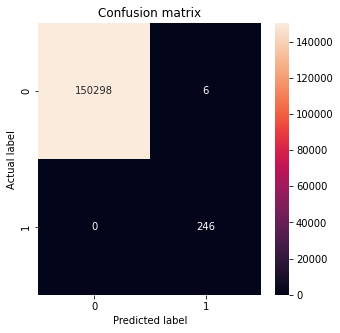

In [36]:
plot_cm(Y_val, history["clf_0"]["y_hat_val"], "RFC_tuned")

# K-fold

In [19]:
Y = data.is_fraud.to_numpy()
X = data.copy().drop("is_fraud", axis = 1).to_numpy()

print("X shape:", X.shape)
print("Y shape:", Y.shape)

X[0:1]

X shape: (940935, 10)
Y shape: (940935,)


array([[0.00000000e+00, 1.67235309e-04, 1.54282568e+09, 0.00000000e+00,
        5.00000000e+00, 8.78346339e+05, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]])

In [20]:
len(Y[Y==1])

1535

In [21]:
indices_split, Test = split_data(X, Y, kfold=5)

In [ ]:
classifier = RandomForestClassifier(max_depth= 50, max_features= 'log2', min_samples_split= 2, 
                                    n_estimators= 400, random_state=RANDOM_STATE, n_jobs= 3,
                                    class_weight= "balanced_subsample", min_samples_leaf= 2, 
                                    verbose=1, oob_score=True)

classifiers = train_model(classifier, X, Y, indices_split, scaling=True)

Training clf 0


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   33.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.9min
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:  3.9min finished


Training clf 1


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   26.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.9min
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:  3.9min finished


Training clf 2


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   26.2s


In [ ]:
history = compare_models(X, Y, classifiers, indices_split, scaling=True)

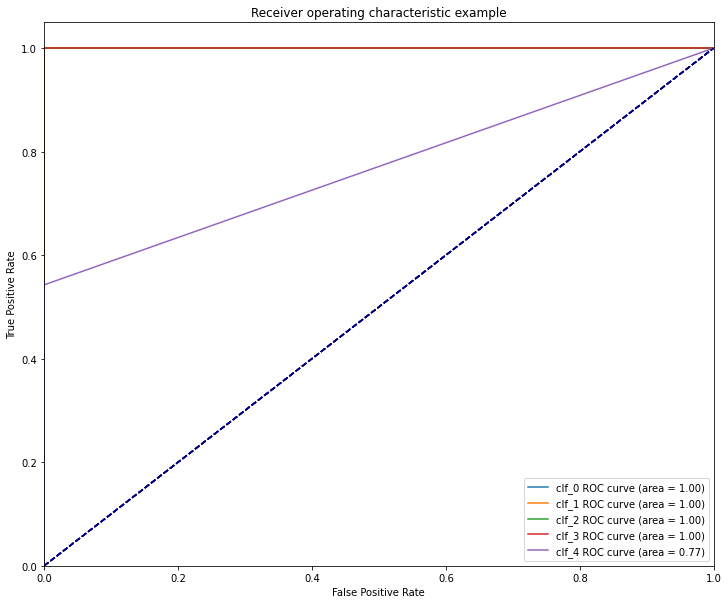

In [27]:
plot_roc_auc_curve(history)

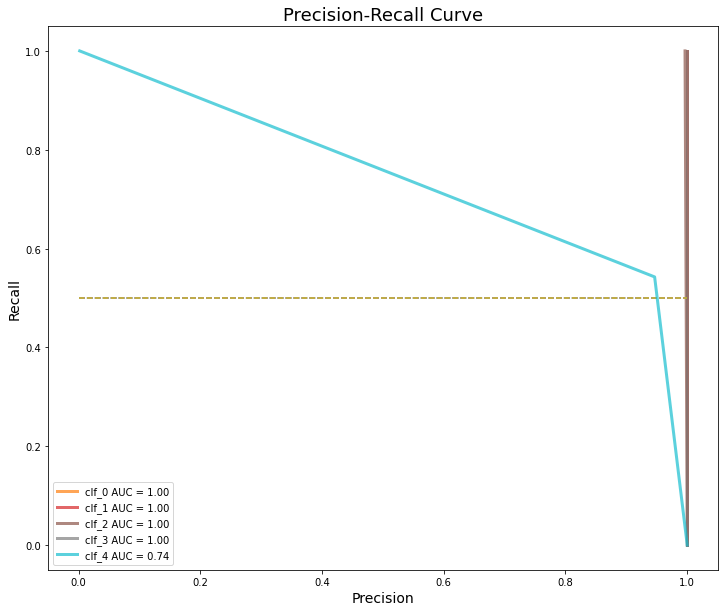

In [28]:
plot_pr_curve(history)

clf_0


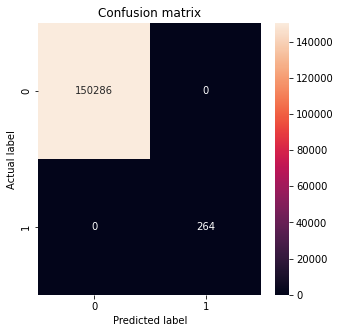

clf_1


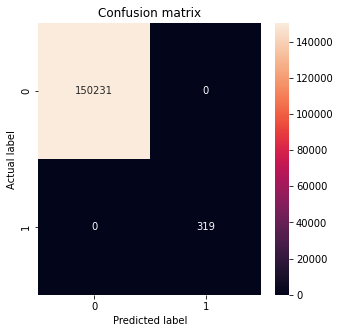

clf_2


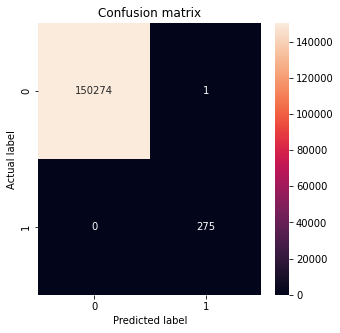

clf_3


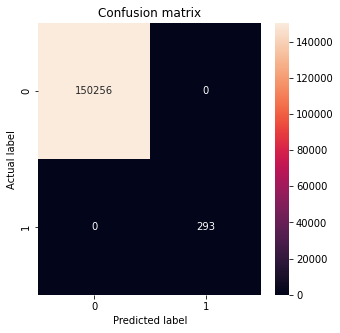

clf_4


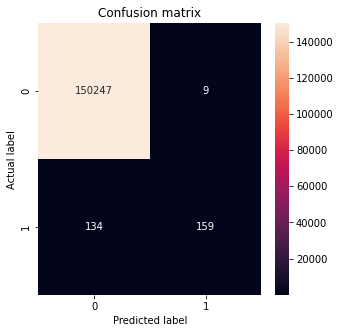

In [29]:
for model_name, model_eval, (train, val) in zip(history.keys(), history.values(),
                                                  indices_split.values()):
    
    plot_cm(Y[val], model_eval["y_hat_val"], model_name)

In [23]:
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (940935, 10)
Y shape: (940935,)


In [75]:
X_pack, Y_pack = split_data(X, Y, kfold=None)

X_train, X_val, X_test = X_pack
Y_train, Y_val, Y_test = Y_pack

# Training model on all dataset

In [ ]:
{'class_weight': 'balanced_subsample',
 'max_depth': 50,
 'min_samples_leaf': 2,
 'min_samples_split': 24,
 'n_estimators': 1000}


{'max_depth': 50,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 400}

{'max_depth': None,
 'max_samples': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400,
 'oob_score': True}

In [101]:
classifier = RandomForestClassifier(max_depth= 50, max_features= 'log2', min_samples_split= 2, 
                                    n_estimators= 400, random_state=RANDOM_STATE, n_jobs= 3,
                                    class_weight= "balanced_subsample", min_samples_leaf= 2, 
                                    verbose=1, oob_score=True)

classifiers = train_model(classifier, train_features, Y_train)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   25.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.2min
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:  4.4min finished


In [102]:
X_train_val = (train_features, val_features)
Y_train_val = (Y_train, Y_val)
history = compare_models(X_train_val, Y_train_val, classifiers)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.3s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    5.2s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:   10.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.3s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    2.0s


F1 score - Train: 0.9999685998186423 / val: 0.9987938077358864
ROC AUC score - Train: 0.9999841986906537 / val: 0.7052612667054391
PR AUC score - val: 0.6733587130236408


[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    3.6s finished


RFC


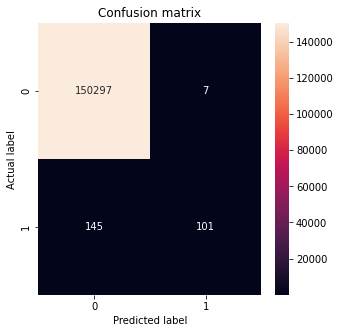

In [106]:
plot_cm(Y_val, history["clf_0"]["y_hat_val"], "RFC")

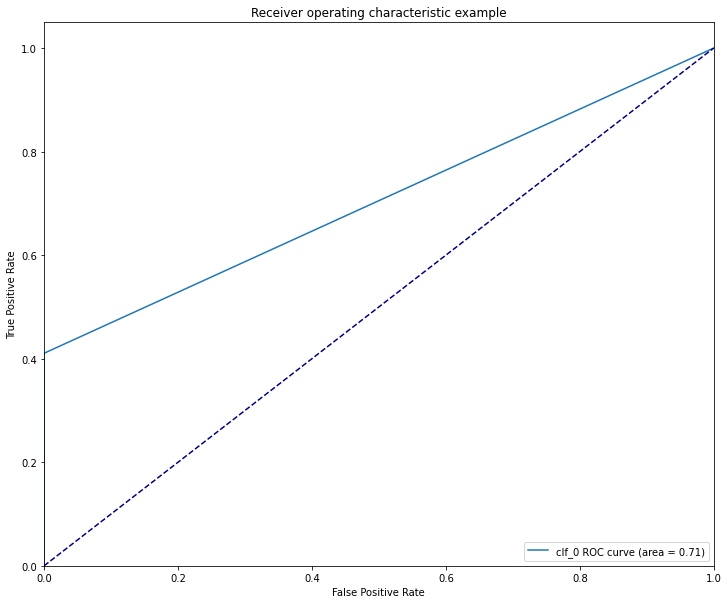

In [107]:
plot_roc_auc_curve(history)

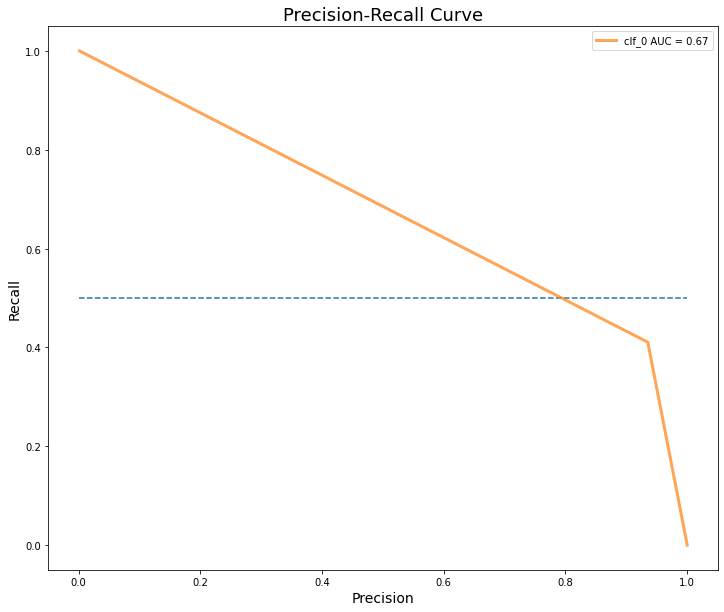

In [108]:
plot_pr_curve(history)

# Testing